# VAE guide

In this tutorial you'll learn how to make your very own variational autoencoder (VAE).
We'll be using Python 3, the [Keras functional API](https://keras.io/getting-started/functional-api-guide/) and numpy. The original paper describing the VAE, can be found [here](https://arxiv.org/abs/1312.6114).

### Autoencoder

First, we need to get an idea of whan an autoencoder is. The goal of an autoencoder is to compress data, yet keeping the information describing the data. The autoencoder will implicitly extract the most descriptive components of the data when compressing it, and it is therefore a commonly used component in creative architectures within DL. The idea behind an autoencoder is relatively simple - push raw data (X) through a shrinking pipeline (q) and make the autoencoder network learn what features to remove and what to keep. Push the shrunken data (z) through an increasing sized pipeline (p), and make the autoencoder network learn what features it needs to add to reproduce the raw input, as shown in the figure below.

<img src="images/autoencoder_Jwaaler.png" title="Auoencoder architecture" width="500"/>

#### Variational autoencoder

Let's think probability. The joint probability of the model above is:

$$p(X,z) = p (X | z)p(z)$$

According to Bayes: $$p(z | X) = \frac{p(X | z)p(z)}{p(X)}$$

Which can be calculated by marginalizing the latent varables:

$$p(X) = \int p(X | z)p(z)dz $$

Which is hard to calculate, as it requires exponentional computational time over all configurations of the latent variables.

This is why we approximate $p(z | X)$ with a family of distributions $q_{\lambda}(z | X)$, where the variational parameter $\lambda$ represents the family of distributions. To calulate the amount of lost information when approximating $p(z | X)$ using $q(z | X)$, [Kullback-Leibler divergence](https://towardsdatascience.com/demystifying-kl-divergence-7ebe4317ee68) is used (which is impossible to compute directly, hence the use of [Evidence Lower BOund](http://edwardlib.org/tutorials/klqp)).

I highly recommend reading [this](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) before you continue. Intuetively, the model is tasked to learn the distribution of the input data.

### Data
Before we continue, we need some data. The data consists of axial, coronal and sagital MR images of the human brain. I've created a script that downloads the data for you. I've also made some functions for loading the data as it is stored as .mat files. Thank you, [Jun Cheng](https://github.com/chengjun583/), for making the data available.

In [1]:
from utils.data_handler import download_data

# First, we download the data - This might take som time. Go grab a coffee
download_data()


Already downloaded, you can continue


In [2]:
from utils.data_handler import extract_data

# Now, lets unzip the data
extract_data()

Already extracted - you can continue


In [3]:
from utils.data_handler import load_data

# Let's load the data
# For this guide, we dont really need test and validation data
# we just want to learn the distribution of the data

x_train = load_data()

print(x_train.shape)

(3049, 512, 512, 1)


Good. You should now have 3049 images with the size 512x512 stored in memory.

### Implementation

First, let's create a function that samples from the latent space, given mean ($\mu$) and variance ($\sigma^2$) as arguments. We sample from an isotropic Gaussian distribution so we can train the network. This process is called the reparameteriazation trick, which you can read about [here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important). Instead of sampling from $q(z | X)$, we sample $\epsilon = N(0,1)$, so that $z = \mu + \sqrt{\sigma^2}\epsilon$

In [4]:
from keras import backend as K


def sampling(input_tensor):
    z_mean, z_log_var = input_tensor
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


Using TensorFlow backend.


In [5]:
# Let's set some parameters for the model
params = {
    'filters': 16, # How many filters should the first convolutional layer contain?
    'latent_dim': 16, # How many distributions should the VAE learn?
    'kernel_size': 3, # How big should the kernels be?
    'input_shape': x_train.shape[1:], # What is the input-shape?
    'last_activation': 'sigmoid' # What should be the last activation?
}

params['filters'] //= 2


In [6]:
from keras.layers import (Input,
                          Dense,
                          Conv2D,
                          Flatten,
                          Lambda)

from keras.models import Model


def encoder(input_shape,
            filters,
            latent_dim,
            kernel_size,
            **kwargs) -> "Model":
    
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs

    # The encoder is "shrinking" the input by stride = 2.
    # The number of filters is increasing by a factor of two for each hidden layer
    for i in range(4):
        filters *= 2
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same',
                   name='encoder_conv_{}'.format(i))(x)

    intermediate_shape = K.int_shape(x)
    
    # The latent vector is created (q(z | X))
    x = Flatten(name='encoder_flatten')(x)
    x = Dense(latent_dim*8, activation='relu', name='encoder_intermediate_layer')(x)
    z_mean = Dense(latent_dim, name='encoder_z_mean')(x)
    z_log_var = Dense(latent_dim, name='encoder_z_log_var')(x)
    
    # Sample z
    z = Lambda(sampling, output_shape=(latent_dim,), name='encoder_z')([z_mean, z_log_var])
    
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    params['filters'] = filters
    return encoder, intermediate_shape


In [7]:
from keras.layers import (Conv2DTranspose,
                          Reshape)


def decoder(prev,
            intermediate_shape,
            latent_dim,
            last_activation,
            kernel_size,
            **kwargs) -> "Model":
    
    filters = intermediate_shape[3]
    intermediate_size = intermediate_shape[1] * intermediate_shape[2] * intermediate_shape[3]
    
    # Upsampling and reshaping to intermediate shape
    latent_inputs = Input(shape=(latent_dim,), name='decoder_sampled_input')
    
    x = Dense(intermediate_size,
              activation='relu',
              name='decoder_intermediate')(latent_inputs)
    
    x = Reshape((intermediate_shape[1:4]),
                name='decoder_reshape')(x)
    
    for i in range(4):
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same',
                            name='decoder_conv_{}'.format(i))(x)
        
        filters //= 2
    
    x = Conv2D(filters=filters//2,
               kernel_size=kernel_size,
               activation='relu',
               padding='same',
               name= 'decoder_conv{}'.format(4))(x)
    
    outputs = Conv2D(filters=1,
                     kernel_size=kernel_size,
                     activation=last_activation,
                     padding='same',
                     name='decoder_output')(x)

    # Make model object
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder


In [8]:
# Instatiating the models - gluing it all together
encoder_model, intermediate_shape = encoder(**params)
decoder_model = decoder(encoder_model.outputs[2], intermediate_shape, **params)

outputs = decoder_model(encoder_model(encoder_model.inputs)[2])

vae = Model(encoder_model.inputs, outputs, name = 'vae')

print('ENCODER')
print(encoder_model.summary())

print('\nDECODER')
print(decoder_model.summary())

print('\nVAE')
print(vae.summary())


ENCODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 256, 256, 16) 160         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 128, 128, 32) 4640        encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv2D)         (None, 64, 64, 64)   18496       encoder_conv_1[0][0]             
__________________________________________________________________________________________________
en

In [9]:
from keras.losses import mse

# Adding loss - both (scaled) reconstruction and KL

reconstruction_loss = mse(K.flatten(encoder_model.inputs), K.flatten(outputs))
reconstruction_loss *= params['input_shape'][0]*params['input_shape'][0]
kl_loss = 1. + encoder_model.outputs[1] - K.square(encoder_model.outputs[0]) - K.exp(encoder_model.outputs[1])
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


In [10]:
# Now it's time to train the model.
# Let's train it with the adam optimizer

vae.compile(optimizer='adam')

# You can change these parameters around, especially the batch_size.
# Remember, the images are large (512x512), so if the training crashes,
# you more than likely have to reduce the batch size. If it still crashes
# well.. You can modify the network to be smaller.
# You can start with 4 filters, for example.
# Or, you could get a GPU with more memory.
# Or rent TPU server from Amazon or Google

# In the first training iteration, we'll train it with batch size of 64
training_params = {
    'epochs': 32,
    'batch_size': 64,
    'shuffle': True,
}

# In this training iteration, we'll train on a much smaller batch size to focus the weights a bit more
history_1 = vae.fit(x_train, **training_params)

training_params = {
    'epochs': 18,
    'batch_size': 4,
    'shuffle': True,
}

history_2 = vae.fit(x_train, **training_params)

Epoch 1/32
3049/3049 [==============================] - 28s 9ms/step - loss: 16166.6715
Epoch 2/32
3049/3049 [==============================] - 23s 8ms/step - loss: 1027.5702
Epoch 3/32
3049/3049 [==============================] - 23s 8ms/step - loss: 1024.6504
Epoch 4/32
3049/3049 [==============================] - 24s 8ms/step - loss: 1019.2713
Epoch 5/32
3049/3049 [==============================] - 24s 8ms/step - loss: 602.2672
Epoch 6/32
3049/3049 [==============================] - 24s 8ms/step - loss: 353.5699
Epoch 7/32
3049/3049 [==============================] - 24s 8ms/step - loss: 297.2219
Epoch 8/32
3049/3049 [==============================] - 24s 8ms/step - loss: 281.3675
Epoch 9/32
3049/3049 [==============================] - 24s 8ms/step - loss: 271.3270
Epoch 10/32
3049/3049 [==============================] - 24s 8ms/step - loss: 263.5240
Epoch 11/32
3049/3049 [==============================] - 24s 8ms/step - loss: 256.3914
Epoch 12/32
3049/3049 [========================

### Evaluation

Ok, we have now trained our model. Let's see how well our model performs.

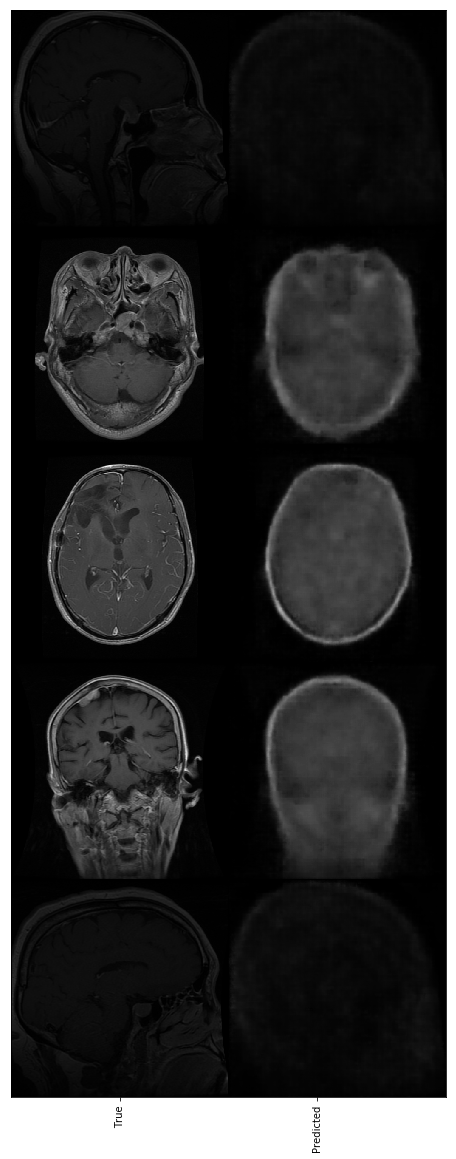

In [13]:
# Ok, lets see how the model does on some data
# Lets predict 5 images, and see how it compares to the original data

vae.save_weights('pretrained_models/pretrained_model_weights.h5')

import matplotlib.pyplot as plt
import numpy as np



nr_of_samples = 5

test_data = x_train[np.random.choice(range(x_train.shape[0]), nr_of_samples)]
y_pred = vae.predict(test_data)
target_shape = (512, 512)

stacked = y_pred[0].reshape(target_shape)
for i in range(1, nr_of_samples):
    stacked = np.vstack([stacked, y_pred[i].reshape(target_shape)])
    
stacked_test = test_data[0].reshape(target_shape)
for i in range(1, nr_of_samples):
    stacked_test = np.vstack([stacked_test, test_data[i].reshape(target_shape)])
    
plt.figure(figsize=(20,20))
plt.imshow(np.hstack([stacked_test, stacked]), cmap='gray')
plt.yticks([])
plt.xticks([256, 720], ['True', 'Predicted'], rotation=90)
plt.show()

OK - not bad. But I think we can do even better. If we assume the distribution is learned, let's and improve the decoder a bit by freezing the encoder.

In [22]:
for layer in encoder_model.layers:
    layer.trainable = False

print(vae.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 512, 512, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  16878624  
_________________________________________________________________
decoder (Model)              (None, 512, 512, 1)       2473305   
Total params: 36,230,553
Trainable params: 19,351,929
Non-trainable params: 16,878,624
_________________________________________________________________
None
